# 1.0 Config Parameters

In [ ]:
BATCH_SIZE = 8
IMG_HEIGHT = IMG_WIDTH = 224
IMG_CHANNEL = 3
BUFFER_SIZE = BATCH_SIZE * 10 # >= total examples

IMG_PATH = "/content/content/makeup_data_official"

#  2.0 Load Data

## 2.1 Unzip

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip -q "/content/drive/MyDrive/makeup_data_official.zip" -d "/content/"

## 2.2 Pre-processing Functions

(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


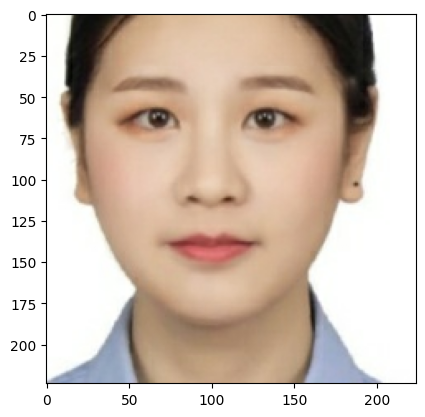

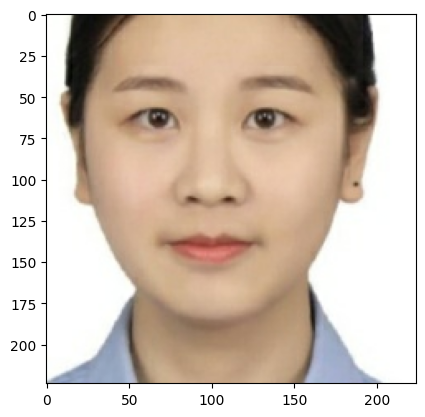

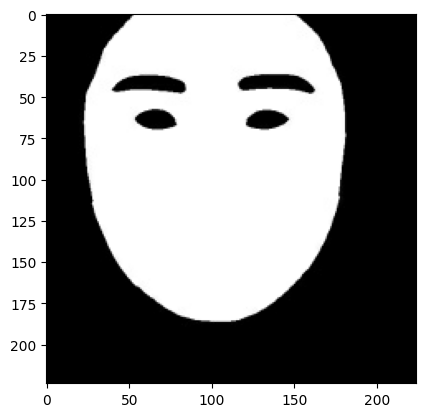

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
def load(image_file):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image,channels=IMG_CHANNEL)

    # Split each image tensor into two tensors:
    # - non-makeup image
    # - makeup image
    w = tf.shape(image)[1]
    w = w // 3
    input_image  = image[:, 0:w, :]
    target_image = image[:, w:2*w, :]
    mask = image[:,2*w:,:]

    input_image  = tf.image.resize(input_image, (IMG_HEIGHT, IMG_WIDTH))
    target_image = tf.image.resize(target_image, (IMG_HEIGHT, IMG_WIDTH))
    mask = tf.image.resize(mask, (IMG_HEIGHT, IMG_WIDTH))

    # Convert both images to float32 tensors
    input_image  = tf.cast(input_image, tf.float32)
    target_image = tf.cast(target_image, tf.float32)
    mask = tf.cast(mask, tf.float32)

    return input_image, target_image, mask

@tf.function()
def random_flip(input_image, target_image):
    if(np.random.uniform(0,1) > 0.5):
        # Random mirroring
        input_image = tf.image.flip_left_right(input_image)
        target_image = tf.image.flip_left_right(target_image)
    return input_image, target_image

def processing_image(input_image, target_image, mask):
    input_image = tf.keras.applications.resnet50.preprocess_input(input_image)
    target_image = target_image / 255.0
    mask = mask / 255.0

    target_image = tf.concat((target_image, mask), axis=1)
    return input_image, target_image

def load_image_train(image_file):
    input_image, target_image, mask = load(image_file)
    # input_image, target_image = random_flip(input_image, target_image)
    input_image, target_image = processing_image(input_image, target_image, mask)
    return input_image, target_image

def load_image_val(image_file):
    input_image, target_image, mask = load(image_file)
    input_image, target_image = processing_image(input_image, target_image, mask)
    return input_image, target_image

input_image, target_image, mask = load(str(IMG_PATH + '/train/1.jpg'))
print(input_image.shape)
print(target_image.shape)
print(mask.shape)

# casting to int for matplotlib to show the image
plt.figure()
plt.imshow(input_image/255)
plt.figure()
plt.imshow(target_image/255)
plt.figure()
plt.imshow(mask/255)

# Train Set
train_dataset = tf.data.Dataset.list_files(str(IMG_PATH + '/train/*.jpg'))
# train_dataset = train_dataset.map(load_image_train,
#                                   num_parallel_calls=tf.data.AUTOTUNE).cache()
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE, seed=42)
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Val set
val_dataset = tf.data.Dataset.list_files(str(IMG_PATH + '/val/*.jpg'))
val_dataset = val_dataset.map(load_image_val)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Test set
test_dataset = tf.data.Dataset.list_files(str(IMG_PATH + '/test/*.jpg'))
test_dataset = test_dataset.map(load_image_val)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [ ]:
for x,y in train_dataset:
  print(y.shape)
  break

(8, 224, 448, 3)


## 2.3 Get length of dataset
length = batch * len(tf.data) because we have batch it

In [ ]:
def get_length(batch_Dataset):
  return len(batch_Dataset) * BATCH_SIZE

In [ ]:
f"Training Samples: {get_length(train_dataset)}"  # val_dataset, test_dataset

'Training Samples: 3000'

## 2.4 Sampling for Keras Tuner

In [ ]:
def Sampling(batch_Dataset, numberOfSamples):
  return batch_Dataset.take(numberOfSamples // BATCH_SIZE)

In [ ]:
train_samples = 1500
val_samples = int(0.3 * train_samples)

In [ ]:
rs_train_dataset = Sampling(train_dataset, train_samples)  # .take batchDataset  .sample for Dataset
print(f"Training Samples: {get_length(rs_train_dataset)}")  # val_dataset, test_dataset

rs_val_dataset = Sampling(val_dataset, val_samples)  # .take batchDataset  .sample for Dataset
print(f"Val Samples: {get_length(rs_val_dataset)}")  # val_dataset, test_dataset

Training Samples: 1496
Val Samples: 448


# 3.0 Config Loss and Metrics



In [ ]:
class Losses_and_Metrics():
    def __init__(self, input_shape):
        self.layer_names = ['block1_conv2', 'block2_conv2', 'block3_conv4', 'block4_conv4', 'block5_conv4']
        self.extractor = self.get_extractor(input_shape)
        self.MSE = tf.keras.losses.MeanSquaredError()
        self.vgg_preprocessing = tf.keras.applications.vgg19.preprocess_input
        self.MAE = tf.keras.losses.MeanAbsoluteError()

    def get_extractor(self, input_shape):
        vgg = tf.keras.applications.VGG19(input_shape=input_shape, include_top=False, weights='imagenet')
        vgg.trainable = False
        outputs = [vgg.get_layer(name).output for name in self.layer_names]
        model = Model(inputs=vgg.input, outputs=outputs)
        return model

    def makeup_loss(self, target_image, fake_image):
        w = target_image.shape[2] // 2
        mask = target_image[:,:,w:,:]

        # Extract face
        face_fake = mask* fake_image
        face_loss = self.mse_loss(mask, face_fake)
        return 600 * face_loss

    def percep_loss(self, target_image, fake_image):
        target_image = target_image[:,:,0:IMG_HEIGHT,:]
        target_image = target_image * 127.5 + 127.5
        fake_image = fake_image * 127.5 + 127.5

        target_image = self.vgg_preprocessing(target_image)
        fake_image = self.vgg_preprocessing(fake_image)

        target_features = self.extractor(target_image)
        fake_features = self.extractor(fake_image)

        loss_perceptual = tf.add_n([tf.reduce_mean((tar_fea-fk_fea)**2)
                         for  tar_fea, fk_fea in zip(target_features, fake_features)])/(len(fake_features))
        return loss_perceptual

    def mae_loss(self, target_image, fake_image):
        target_image = target_image[:,:,0:IMG_HEIGHT,:]
        return self.MAE(target_image,fake_image)

    def mse_loss(self, target_image, fake_image):
        target_image = target_image[:,:,0:IMG_HEIGHT,:]
        return self.MSE(target_image,fake_image)

    def my_loss(self, target_image, fake_image):
        percep = self.percep_loss(target_image, fake_image) # (0-15000)
        makeup = tf.cast(self.makeup_loss(target_image, fake_image), tf.float32) #(0-100)
        return percep + makeup * 10

    # Metrics
    def psnr(self, y_true, y_pred):
        return tf.image.psnr(y_true[:,:,:IMG_HEIGHT,:],y_pred,1.0)
    def ssim(self, y_true, y_pred):
        return tf.image.ssim(y_true[:,:,:IMG_HEIGHT,:],y_pred,1.0)

# 4.0 Build Model

### 4.1 Model Architecture with Mannual

In [ ]:
import gdown, os
import keras
from tensorflow.keras.models import Model
from tensorflow.keras import layers

class de_Makeup_Model:
    def __init__(self, transfer_learning=False):
        self.transfer_learning = transfer_learning

    def ResNet50(self, input) -> Model:
        encoder_blocks_name = ["conv1_relu", "conv2_block3_out", "conv3_block4_out",
                                    "conv4_block6_out"]
        model = tf.keras.applications.ResNet50(include_top=False, input_tensor=input,
                                        weights='imagenet')
        model.trainble = False
        return encoder_blocks_name, Model(inputs=model.input, outputs=model.output, name='encoder')

    def VGG_Face(self, input) -> Model:
        encoder_blocks_name = ["conv2d_1", "conv2d_3", "conv2d_6",
                                        "conv2d_9", "conv2d_12", "max_pooling2d_4"]
        num_filters = [64, 128, 256, 512, 512]
        num_layers = [2, 2, 3, 3, 3]

        for f in range(len(num_filters)):
          for l in range(num_layers[f]):
            if f == 0 and l == 0: x = layers.ZeroPadding2D((1,1))(input)
            else: x = layers.ZeroPadding2D((1,1))(x)
            x = layers.Convolution2D(num_filters[f], (3, 3), activation='relu')(x)
          x = layers.MaxPooling2D((2,2), strides=(2,2))(x)

        x = layers.Convolution2D(4096, (7, 7), activation='relu')(x)
        x = layers.Dropout(0.5)(x)
        x = layers.Convolution2D(4096, (1, 1), activation='relu')(x)
        x = layers.Dropout(0.5)(x)
        x = layers.Convolution2D(2622, (1, 1))(x)
        x = layers.Flatten()(x)
        x = layers.Activation('softmax')(x)
        model = Model(inputs=input, outputs=x)

        if self.transfer_learning:
          output_path = 'vgg_face_weights.h5'
          if os.path.isfile(output_path) != True:
            model_url = 'https://github.com/serengil/deepface_models/releases/download/v1.0/vgg_face_weights.h5'
            gdown.download(model_url, output_path, quiet=False)
          model.load_weights(output_path)
          model.trainable = False

        return encoder_blocks_name, Model(inputs=model.input, outputs=model.layers[-3].output, name='encoder')

    def conv_block(self, inputs, num_filters):
        x = layers.Conv2D(filters=num_filters, kernel_size=(3,3), padding="same")(inputs)
        x = layers.BatchNormalization()(x)
        x = layers.LeakyReLU()(x)

        x = layers.Conv2D(filters=num_filters, kernel_size=(3,3), padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.LeakyReLU()(x)
        return x

    def upsample_concate_block(self, inputs, skip_connection, num_filters, strides=2, kernel_size=2):
        x = layers.Conv2DTranspose(filters=num_filters, kernel_size=kernel_size, strides=strides, output_padding = 0)(inputs)
        x = layers.Concatenate()([skip_connection, x])
        x = self.conv_block(x, num_filters)
        x = self.conv_block(x, num_filters)
        return x

    def build_model(self, pre_trained=None):
        # Free up RAM in case the model definition cells were run multiple times
        keras.backend.clear_session()


        inputs = keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH) + (3,))
        ### [First half of the network: downsampling inputs] ###
        encoder_blocks_name, backbone  = self.ResNet50(inputs)
        ### [First half of the network: downsampling inputs] ###
        encoder_blocks = []
        for i in range(len(encoder_blocks_name)):
          encoder_blocks.append(backbone.get_layer(name=encoder_blocks_name[i]).output)
          # print(encoder_blocks[i])

        # bridge
        br = backbone.output

        # decoder
        db5 = self.upsample_concate_block(inputs=br, skip_connection=encoder_blocks[-1], num_filters=256)
        db4 = self.upsample_concate_block(inputs=db5, skip_connection=encoder_blocks[-2], num_filters=256)
        db3 = self.upsample_concate_block(inputs=db4, skip_connection=encoder_blocks[-3], num_filters=128)
        db2 = self.upsample_concate_block(inputs=db3, skip_connection=encoder_blocks[-4], num_filters=64)

        # final output
        first_feature = layers.Conv2D(filters=64, kernel_size=(3,3), padding='same')(inputs)
        final_feature = self.upsample_concate_block(inputs=db2, skip_connection=first_feature, num_filters=64)
        outputs = layers.Conv2D(filters=3, kernel_size=(1,1), activation='tanh')(final_feature)

        # Define the model
        model = keras.Model(backbone.input, outputs, name='de-makeup')

        if pre_trained != None:
          model.load_weights(pre_trained)
          print(f"Load {pre_trained} successfully")
        return model

In [ ]:
model = de_Makeup_Model().build_model()
model.summary()

94765736/94765736 [==============================] - 1s 0us/step
Model: "de-makeup"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                     

### 4.2 Model Architecture with Keras Tuner

In [ ]:
from tensorflow.keras import layers
import keras

def conv_block(inputs, num_filters):
    x = layers.Conv2D(filters=num_filters, kernel_size=(3,3), padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    return x

def upsample_concate_block(inputs, skip_connection, num_filters, hp, strides=2, kernel_size=2):
    x = layers.Conv2DTranspose(filters=num_filters, kernel_size=kernel_size, strides=strides, output_padding = 0)(inputs)
    if skip_connection != None:
      x = layers.Concatenate()([skip_connection, x])
    for i in range(hp.Int('num_conv_block', 1, 3, step=1)):
      x = conv_block(x, num_filters)
    return x

def build_model(hp): # hp stands for hyperparameter
    # Free up RAM in case the model definition cells were run multiple times
    keras.backend.clear_session()

    # encoder_blocks_name = ["Conv2d_2b_3x3_Activation", "Conv2d_4a_3x3_Activation",
    #                        "Block35_1_Activation", "Mixed_6a", "Mixed_7a"]

    encoder_blocks_name = ["conv2d_1", "conv2d_3", "conv2d_6",
                                    "conv2d_9", "conv2d_12", "max_pooling2d_4"]

    inputs = keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH) + (3,))

    ### [First half of the network: downsampling inputs] ###
    backbone = VGG_16_Face(inputs)

    ### [First half of the network: downsampling inputs] ###
    encoder_blocks = []
    for i in range(len(encoder_blocks_name)):
      encoder_blocks.append(backbone.get_layer(name=encoder_blocks_name[i]).output)

    # bridge
    br = layers.UpSampling2D(size=(2, 2))(backbone.output)

    # decoder
    db5 = upsample_concate_block(inputs=br, skip_connection=encoder_blocks[-1],  hp=hp, num_filters=1024, strides=3, kernel_size=4)
    db4 = upsample_concate_block(inputs=db5, skip_connection=encoder_blocks[-2], hp=hp, num_filters=1024)
    db3 = upsample_concate_block(inputs=db4, skip_connection=encoder_blocks[-3], hp=hp, num_filters=512)
    db2 = upsample_concate_block(inputs=db3, skip_connection=encoder_blocks[-4], hp=hp, num_filters=256)
    db1 = upsample_concate_block(inputs=db2, skip_connection=encoder_blocks[-5], hp=hp, num_filters=128)
    db0 = upsample_concate_block(inputs=db1, skip_connection=encoder_blocks[-6], hp=hp, num_filters=64)

    outputs = layers.Conv2D(filters=3, kernel_size=(1,1), activation='sigmoid')(db0)

    # Define the model
    model = keras.Model(inputs, outputs, name='de-makeup')
    optimizer = tf.keras.optimizers.AdamW(0.001)
    loss_func = MyLoss(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNEL))

    model.compile(optimizer=optimizer, loss=loss_func.my_loss, metrics=[ssim, psnr])
    return model

Instantiate the Tuner and perform hypertuning

Now that you have the model builder, you can then define how the tuner can find the optimal set of hyperparameters, also called the search strategy. Keras Tuner has [four tuners](https://keras-team.github.io/keras-tuner/documentation/tuners/) available with built-in strategies - `RandomSearch`, `Hyperband`, `BayesianOptimization`, and `Sklearn`.

In this tutorial, you will use the Hyperband tuner. Hyperband is an algorithm specifically developed for hyperparameter optimization. It uses adaptive resource allocation and early-stopping to quickly converge on a high-performing model. This is done using a sports championship style bracket wherein the algorithm trains a large number of models for a few epochs and carries forward only the top-performing half of models to the next round. You can read about the intuition behind the algorithm in section 3 of [this paper](https://arxiv.org/pdf/1603.06560.pdf).

Hyperband determines the number of models to train in a bracket by computing 1 + log<sub>`factor`</sub>(`max_epochs`) and rounding it up to the nearest integer. You will see these parameters (i.e. `factor` and `max_epochs` passed into the initializer below). In addition, you will also need to define the following to instantiate the Hyperband tuner:

* the hypermodel (built by your model builder function)
* the `objective` to optimize (e.g. validation accuracy)
* a `directory` to save logs and checkpoints for every trial (model configuration) run during the hyperparameter search. If you re-run the hyperparameter search, the Keras Tuner uses the existing state from these logs to resume the search. To disable this behavior, pass an additional `overwrite=True` argument while instantiating the tuner.
* the `project_name` to differentiate with other runs. This will be used as a subdirectory name under the `directory`.

You can refer to the [documentation](https://keras.io/api/keras_tuner/tuners/hyperband/) for other arguments you can pass in.

For example, if factor is set to 3 and hyperband_iterations is set to 2:

Total Trials = (3^(2 + 1)) = 27

In [ ]:
work_dir = "/content"

In [ ]:
# tuner = keras_tuner.BayesianOptimization(
#     hypermodel=build_model,
#     objective="val_loss",
#     max_trials=8,
#     overwrite=False,
#     directory=work_dir,
#     project_name="de_makeup_tuner",
# )

tuner = keras_tuner.Hyperband(
    hypermodel=build_model,
    objective="val_loss",
    max_epochs=20,
    factor=4,
    hyperband_iterations=1,
    overwrite=True,
    directory=work_dir,
    project_name="de_makeup_tuner")

# Configure TensorBoard
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='tensorboard_logs', histogram_freq=1)

tuner.search_space_summary()

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-10-ab735d5b3d93>", line 10, in <cell line: 10>
    tuner = keras_tuner.Hyperband(
NameError: name 'keras_tuner' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2099, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/ultratb.py", line 1101, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/usr/local/lib/python3.10/dist-packages

TypeError: object of type 'NoneType' has no len()

In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

In [ ]:
tuner.search(rs_train_dataset, validation_data=rs_val_dataset, epochs=20, callbacks=[stop_early], verbose=1)

In [ ]:
best_hp = tuner.get_best_hyperparameters()[0]

In [ ]:
best_hp.values

In [ ]:
%load_ext tensorboard
%tensorboard --logdir=tensorboard_logs

In [ ]:
best_hp = keras_tuner.HyperParameters()
best_hp.values = {'num_conv_block': 2,
 'tuner/epochs': 2,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 2,
 'tuner/round': 0}

In [ ]:
model = tuner.hypermodel.build(best_hp)
model.summary()

In [ ]:
del tuner

# 5.0 Training

## 5.1 Display

In [ ]:
from IPython.display import clear_output
import numpy as np
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)

    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

    for x, y in train_dataset.take(1):
      input_image = x.numpy()[0]
      target_image = y.numpy()[0]
      x_test = np.expand_dims(input_image,axis=0)

      fake = self.model.predict(x_test)

      mean = np.array([103.939, 116.779, 123.68])
      mean = mean.reshape((1,1,3))
      temp = input_image + mean
      temp = input_image[..., ::-1]

      title = ['Input', 'Predicted', 'Real']
      plt.figure(figsize=(15,20))

      display_list = [temp/255.0, fake[0],  target_image[:,:IMG_HEIGHT,:]]

      for i in range(3):
          plt.subplot(1, 3, i+1)
          plt.title(title[i])
          plt.imshow(display_list[i])
          plt.axis('off')
          # plt.savefig('output.png',bbox_inches='tight')
      plt.show()

## 5.2 Checkpoint

In [ ]:
from keras.callbacks import ModelCheckpoint
import datetime

e = datetime.datetime.now()
date =  ("%s_%s_%s" % (e.day, e.month, e.year))
# checkpoint
filepath=f"/content/drive/MyDrive/Unet_demakeup_{date}.h5"
print(filepath)
checkpoint = ModelCheckpoint(filepath, monitor='val_loss',
                             verbose=1, save_best_only=True,
                             mode='min', save_weights_only = True,
                             initial_value_threshold = None)

/content/drive/MyDrive/Unet_demakeup_5_2_2024.h5


## 5.3 Early Stop

In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

## 5.4 Configure TensorBoard

In [ ]:
tensorboard = tf.keras.callbacks.TensorBoard(log_dir='tensorboard_train_logs', histogram_freq=1)

In [ ]:
callbacks_list = [checkpoint, stop_early, DisplayCallback()]

In [ ]:
!pip install tensorflow_addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 3.7 MB/s eta 0:00:00


In [ ]:
import tensorflow_addons as tfa
def scale_fn(x):
    return 1. ** x

wd = tf.optimizers.schedules.PiecewiseConstantDecay(
    [10000, 15000], [1e-4, 1e-5, 1e-6])

INIT_LR = 1e-5
MAX_LR = INIT_LR * 100
steps_per_epoch = 1496/ BATCH_SIZE
clr = tfa.optimizers.CyclicalLearningRate(initial_learning_rate=INIT_LR,
    maximal_learning_rate=MAX_LR,
    scale_fn=scale_fn,
    step_size=2 * steps_per_epoch
)

optimizer = tfa.optimizers.AdamW(learning_rate=clr, weight_decay=wd, amsgrad=True)
loss_func = Losses_and_Metrics(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNEL))

In [ ]:
model.load_weights('/content/drive/MyDrive/Unet_demakeup_3_2_2024.h5')

In [ ]:
model.compile(optimizer=optimizer, loss=loss_func.my_loss, metrics=[loss_func.ssim, loss_func.psnr])


Sample Prediction after epoch 13

1/1 [==============================] - 0s 24ms/step


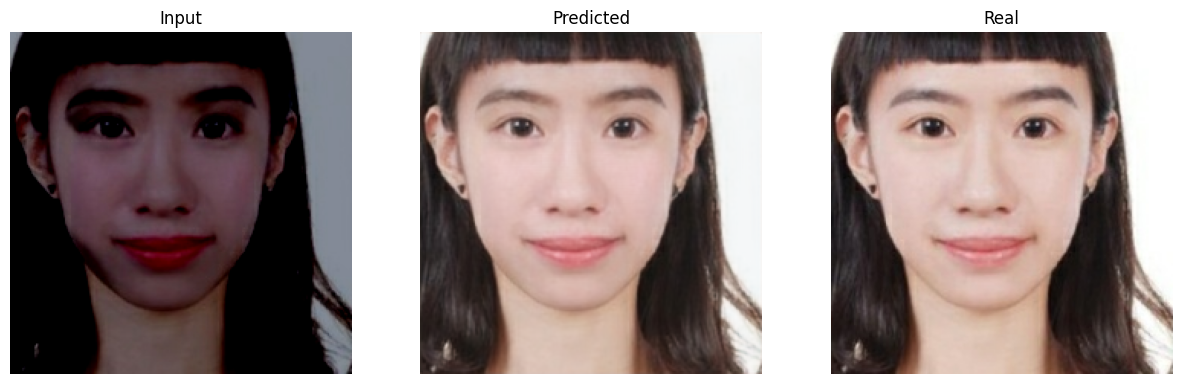

375/375 [==============================] - 256s 683ms/step - loss: 1043.7109 - ssim: 0.9521 - psnr: 29.4619 - val_loss: 1981.3929 - val_ssim: 0.9454 - val_psnr: 28.4559


In [ ]:
history = model.fit(train_dataset, validation_data =val_dataset, epochs = 50, callbacks=callbacks_list, verbose = 1)

# 6.0 MLOPs

# New Section

In [ ]:
!pip install -q tensorflow-model-optimization
!pip install -q -U tensorflow_addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.2/241.2 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 4.4 MB/s eta 0:00:00


## 6.1 Converter

In [ ]:
import tempfile
import zipfile
def print_metric(metric_dict, metric_name):
  '''Prints key and values stored in a dictionary'''
  for metric, value in metric_dict.items():
    print(f'{metric_name} for {metric}: {value}')

def get_gzipped_model_size(file):
  '''Returns size of gzipped model, in bytes.'''
  _, zipped_file = tempfile.mkstemp('.zip')
  with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
    f.write(file)

  return os.path.getsize(zipped_file) * 0.000001 # byte to megabyte

In [ ]:
def convert_tflite(model, filename, quantize=False):
  '''
  Converts the model to TF Lite format and writes to a file

  Args:
    model (Keras model) - model to convert to TF Lite
    filename (string) - string to use when saving the file
    quantize (bool) - flag to indicate quantization

  Returns:
    None
  '''

  # Initialize the converter
  converter = tf.lite.TFLiteConverter.from_keras_model(model)

  # Set for quantization if flag is set to True
  if quantize:
    converter.optimizations = [tf.lite.Optimize.DEFAULT]

  # Convert the model
  tflite_model = converter.convert()

  # Save the model.
  with open(filename, 'wb') as f:
    f.write(tflite_model)

## 6.2 Model optimization/ compression

In [ ]:
import os
# GLOBAL VARIABLES
root = '/content/drive/MyDrive/models'

# String constants for model filenames
FILE_WEIGHTS = os.path.join(root,'baseline_weights.h5')
FILE_NON_QUANTIZED_TFLITE = os.path.join(root,'non_quantized.tflite')
FILE_PT_QUANTIZED = os.path.join(root,'post_training_quantized.tflite')
FILE_PRUNED_MODEL_H5 = os.path.join(root,'pruned_model.h5')
FILE_PRUNED_QUANTIZED_TFLITE = os.path.join(root,'pruned_quantized.tflite')
FILE_SPARSITY_CLUSTERED_MODEL_H5 = os.path.join(root,'sparsity_clustered_model.h5')
FILE_SPARSITY_CLUSTERED_MODEL_TFLITE = os.path.join(root,'pruned_sparsity_clustered.tflite')

FILE_QAT_QUANTIZED = 'quant_aware_quantized.tflite'

# Dictionaries to hold measurements
MODEL_SIZE = {}
ACCURACY = {}

### TF Lite format

In [ ]:
# Convert baseline model
convert_tflite(model, FILE_NON_QUANTIZED_TFLITE)

In [ ]:
MODEL_SIZE['non quantized tflite'] = get_gzipped_model_size(FILE_NON_QUANTIZED_TFLITE)
print_metric(MODEL_SIZE, 'model size in bytes')

model size in bytes for non quantized tflite: 596.6352009999999


### Post-Training Quantization + TF Lite format

In [ ]:
# Convert and quantize the baseline model
convert_tflite(model, FILE_PT_QUANTIZED, quantize=True)

In [ ]:
# Get the model size
MODEL_SIZE['post training quantized tflite'] = os.path.getsize(FILE_PT_QUANTIZED)
print_metric(MODEL_SIZE, 'model size')

model size for post training quantized tflite: 160403952


### Sparsity preserving clustering

In [ ]:
import tensorflow_model_optimization as tfmot
from tensorflow_model_optimization.python.core.clustering.keras.experimental import (
    cluster,
)
CentroidInitialization = tfmot.clustering.keras.CentroidInitialization
cluster_weights = cluster.cluster_weights

clustering_params = {
  'number_of_clusters': 8,
  'cluster_centroids_init': CentroidInitialization.KMEANS_PLUS_PLUS,
  'preserve_sparsity': True
}

stripped_pruned_model = build_model()
stripped_pruned_model.load_weights(FILE_PRUNED_MODEL_H5)
stripped_pruned_model.trainable = True

sparsity_clustered_model = cluster_weights(stripped_pruned_model, **clustering_params)

optimizer = keras.optimizers.Adam(learning_rate=0.0001)
loss_func = MyLoss(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNEL))
sparsity_clustered_model.compile(optimizer=optimizer, loss=loss_func.my_loss, metrics=[ssim, psnr])

80134624/80134624 [==============================] - 0s 0us/step


In [ ]:
callbacks_list = [tfmot.sparsity.keras.UpdatePruningStep()]

In [ ]:
history = sparsity_clustered_model.fit(train_dataset, validation_data =val_dataset, epochs = 5, callbacks=callbacks_list, verbose = 1)

Epoch 1/5
375/375 [==============================] - 601s 1s/step - loss: 10419.0127 - ssim: 0.9056 - psnr: 24.5610 - val_loss: 7418.4839 - val_ssim: 0.9207 - val_psnr: 25.6607
Epoch 2/5
375/375 [==============================] - 576s 2s/step - loss: 6188.5381 - ssim: 0.9344 - psnr: 26.8653 - val_loss: 6866.7266 - val_ssim: 0.9282 - val_psnr: 25.9548
Epoch 3/5
375/375 [==============================] - 531s 1s/step - loss: 5857.2578 - ssim: 0.9376 - psnr: 27.0512 - val_loss: 6890.7217 - val_ssim: 0.9312 - val_psnr: 26.4076
Epoch 4/5
375/375 [==============================] - 581s 2s/step - loss: 5433.3462 - ssim: 0.9397 - psnr: 27.4318 - val_loss: 6237.7866 - val_ssim: 0.9352 - val_psnr: 26.5269
Epoch 5/5
375/375 [==============================] - 537s 1s/step - loss: 5022.1899 - ssim: 0.9405 - psnr: 27.7328 - val_loss: 6030.0552 - val_ssim: 0.9267 - val_psnr: 26.6381


In [ ]:
# Prepare model for serving by removing training-only variables.
stripped_sparsity_clustered_model = tfmot.clustering.keras.strip_clustering(sparsity_clustered_model)

In [ ]:
stripped_sparsity_clustered_model.save(FILE_SPARSITY_CLUSTERED_MODEL_H5, include_optimizer=False)

### Pruning

In [ ]:
# Convert and quantize the pruned model.
convert_tflite(stripped_sparsity_clustered_model, FILE_SPARSITY_CLUSTERED_MODEL_TFLITE, quantize=True)

In [ ]:
stripped_sparsity_clustered_model.save(FILE_SPARSITY_CLUSTERED_MODEL_TFLITE, include_optimizer=True)

In [ ]:
import tensorflow_model_optimization as tfmot
import numpy as np
prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

num_images = 3000
epoch = 10
end_step = np.ceil(num_images / BATCH_SIZE).astype(np.int32) * epoch

# Define model for pruning.
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.ConstantSparsity(0.5, begin_step=0, frequency=50)
  }


model = build_model()
model.load_weights(FILE_WEIGHTS)

pruned_model = prune_low_magnitude(model, **pruning_params)
# `prune_low_magnitude` requires a recompile.
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
loss_func = MyLoss(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNEL))
pruned_model.compile(optimizer=optimizer, loss=loss_func.my_loss, metrics=[ssim, psnr])

80134624/80134624 [==============================] - 0s 0us/step


In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=1, restore_best_weights=True)

In [ ]:
callbacks_list = [stop_early, DisplayCallback(), tfmot.sparsity.keras.UpdatePruningStep()]

1/1 [==============================] - 0s 47ms/step


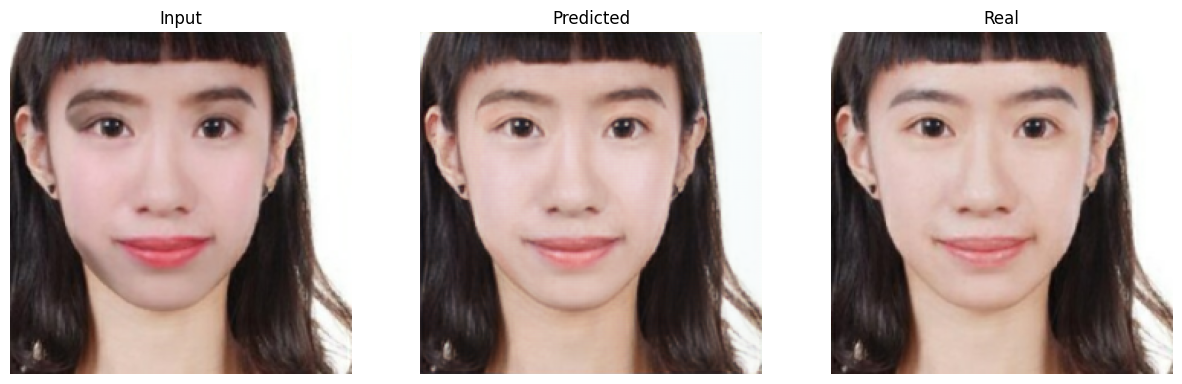


Sample Prediction after epoch 10

375/375 [==============================] - 244s 650ms/step - loss: 5805.2485 - ssim: 0.9307 - psnr: 26.0136 - val_loss: 6646.8623 - val_ssim: 0.9299 - val_psnr: 26.2787


In [ ]:
history = pruned_model.fit(train_dataset, validation_data =val_dataset, epochs = epoch, callbacks=callbacks_list, verbose = 1)

In [ ]:
# Remove pruning wrappers
model_for_export = tfmot.sparsity.keras.strip_pruning(pruned_model)

In [ ]:
model_for_export.save(FILE_PRUNED_MODEL_H5, include_optimizer=False)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
pruned_model = build_model()
pruned_model.load_weights(FILE_PRUNED_MODEL_H5)

### Pruned + Quantization + TF Lite format

In [ ]:
import numpy as np
def print_model_weights_sparsity(model):

    for layer in model.layers:
        if isinstance(layer, tf.keras.layers.Wrapper):
            weights = layer.trainable_weights
        else:
            weights = layer.weights
        for weight in weights:
            if "kernel" not in weight.name or "centroid" in weight.name:
                continue
            weight_size = weight.numpy().size
            zero_num = np.count_nonzero(weight == 0)
            print(
                f"{weight.name}: {zero_num/weight_size:.2%} sparsity ",
                f"({zero_num}/{weight_size})",
            )

In [ ]:
print_model_weights_sparsity(pruned_model)

conv2d_transpose/kernel:0: 50.00% sparsity  (3020544/6041088)
conv2d_16/kernel:0: 50.00% sparsity  (884736/1769472)
conv2d_17/kernel:0: 50.00% sparsity  (294912/589824)
conv2d_18/kernel:0: 50.00% sparsity  (294912/589824)
conv2d_19/kernel:0: 50.00% sparsity  (294912/589824)
conv2d_transpose_1/kernel:0: 50.00% sparsity  (131072/262144)
conv2d_20/kernel:0: 50.00% sparsity  (884736/1769472)
conv2d_21/kernel:0: 50.00% sparsity  (294912/589824)
conv2d_22/kernel:0: 50.00% sparsity  (294912/589824)
conv2d_23/kernel:0: 50.00% sparsity  (294912/589824)
conv2d_transpose_2/kernel:0: 50.00% sparsity  (65536/131072)
conv2d_24/kernel:0: 50.00% sparsity  (368640/737280)
conv2d_25/kernel:0: 50.00% sparsity  (73728/147456)
conv2d_26/kernel:0: 50.00% sparsity  (73728/147456)
conv2d_27/kernel:0: 50.00% sparsity  (73728/147456)
conv2d_transpose_3/kernel:0: 50.00% sparsity  (16384/32768)
conv2d_28/kernel:0: 50.00% sparsity  (92160/184320)
conv2d_29/kernel:0: 50.00% sparsity  (18432/36864)
conv2d_30/kernel:

In [ ]:
# Remove pruning wrappers
model_for_export = tfmot.sparsity.keras.strip_pruning(pruned_model)
# model_for_export.summary()

# Convert and quantize the pruned model.
convert_tflite(model_for_export, FILE_PRUNED_QUANTIZED_TFLITE, quantize=True)

# Compress and get the model size
MODEL_SIZE['pruned quantized tflite'] = get_gzipped_model_size(FILE_PRUNED_QUANTIZED_TFLITE)
print_metric(MODEL_SIZE, "gzipped model size in bytes")

gzipped model size in bytes for pruned quantized tflite: 64.828294


In [ ]:
os.path.getsize(FILE_PRUNED_QUANTIZED_TFLITE)

160422672

# 7.0 Evaluation

## 7.1 Model Size

In [ ]:
import matplotlib.pyplot as plt
import os

root = '/content/drive/MyDrive/models'

info_dict = {'baseline': 'baseline_weights.h5', 'baseline_tflite': 'non_quantized.tflite', 'pruned': 'pruned_model.h5',
        'sparsity_clustered': 'sparsity_clustered_model.h5','pruned_quantized': 'pruned_quantized.tflite',
        'quantized_tflite': 'post_training_quantized.tflite', 'pruned_sparsity_clustered_tflite': 'pruned_sparsity_clustered.tflite'}

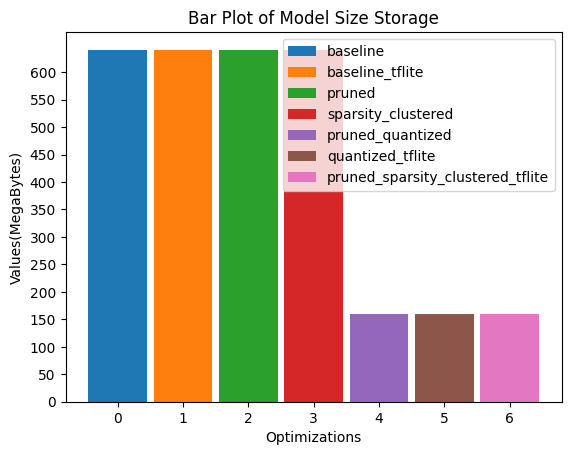

In [ ]:
# Create a list of data to plot
data = [round(os.path.getsize(os.path.join(root,path))* 0.000001, 3) for path in info_dict.values()]
x_labels = [n for n in info_dict.keys()]

# Plotting the bar plot
bar_width = 0.9
index = np.arange(len(x_labels))

for i, category in enumerate(x_labels):
    plt.bar(index[i], data[i], bar_width, label=category)

# Adding labels and title
plt.xlabel('Optimizations')
plt.ylabel('Values(MegaBytes)')
plt.title('Bar Plot of Model Size Storage')

# Adding legend
plt.legend()

# Adjusting the y-axis tick marks
plt.yticks(np.arange(0, max(data)+1, 50))

# Display the plot
plt.show()

## 7.2 Model Inference

Keras Format

In [ ]:
model = de_Makeup_Model().build_model('/content/drive/MyDrive/models/pruned_model.h5')

In [ ]:
def calculate_average_inference_time(model, input_data, num_iterations=100):
    total_time = 0

    for _ in range(num_iterations):
      for x, y in test_dataset:
          start_time = time.time()
          model.predict(x)
          end_time = time.time()
          inference_time = end_time - start_time
          total_time += inference_time

    average_time = total_time / num_iterations
    return average_time

In [ ]:
def evaluate_model(interpreter):
  input_index = interpreter.get_input_details()[0]["index"]
  output_index = interpreter.get_output_details()[0]["index"]

  # Run predictions on ever y image in the "test" dataset.
  input_image, target_image = load_image_val(str(IMG_PATH + '/train/545.jpg'))
  x_test = np.expand_dims(input_image,axis=0).astype(np.float32)

  # Pre-processing: add batch dimension and convert to float32 to match with
  # the model's input data format.
  #test_image = np.expand_dims(test_image, axis=0).astype(np.float32)
  interpreter.set_tensor(input_index, x_test)

  # Run inference.
  interpreter.invoke()

  # Post-processing: remove batch dimension and find the digit with highest
  # probability.
  fake = interpreter.get_tensor(output_index)
  mean = np.array([103.939, 116.779, 123.68])
  mean = mean.reshape((1,1,3))
  temp = input_image + mean
  temp = temp[..., ::-1]

  title = ['Input', 'Predicted', 'Real']
  plt.figure(figsize=(15,20))

  display_list = [temp/255, fake[0],  target_image[:,:IMG_HEIGHT,:]]

  for i in range(3):
      plt.subplot(1, 3, i+1)
      plt.title(title[i])
      plt.imshow(display_list[i])
      plt.axis('off')
      # plt.savefig('output.png',bbox_inches='tight')
  plt.show()

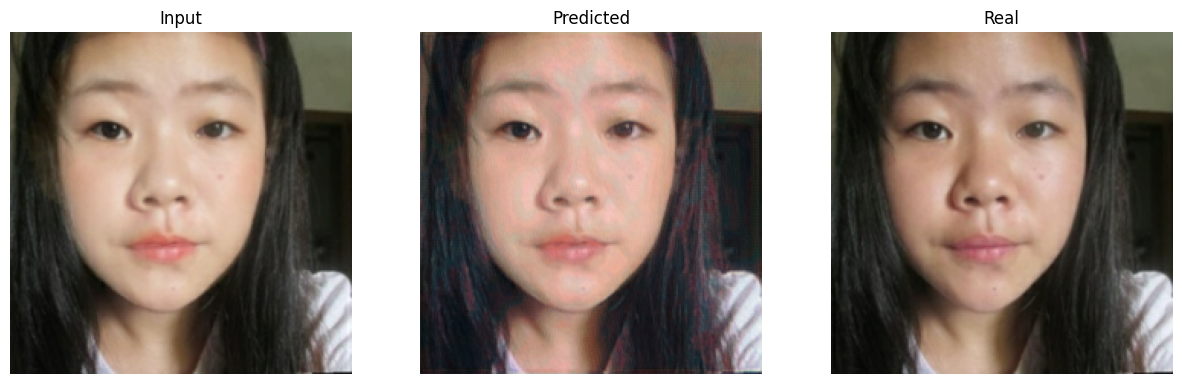

In [ ]:
path = '/content/drive/MyDrive/models/pruned_sparsity_clustered.tflite'
interpreter = tf.lite.Interpreter(model_path=path)
interpreter.allocate_tensors()

evaluate_model(interpreter)

In [ ]:
model = de_Makeup_Model().build_model('/content/drive/MyDrive/models/sparsity_clustered_model.h5')

Load /content/drive/MyDrive/models/sparsity_clustered_model.h5 successfully


1/1 [==============================] - 1s 1s/step


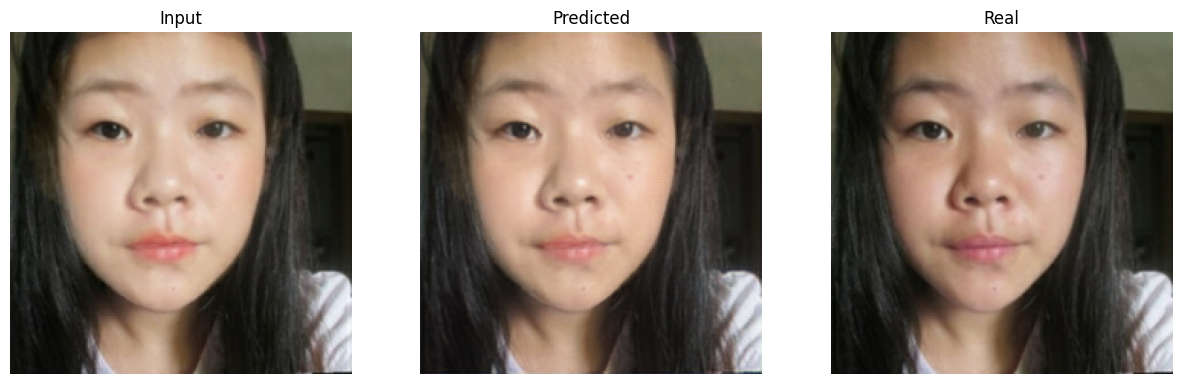

In [ ]:
input_image, target_image = load_image_val(str(IMG_PATH + '/train/545.jpg'))
x_test = np.expand_dims(input_image,axis=0).astype(np.float32)

fake = model.predict(x_test)
mean = np.array([103.939, 116.779, 123.68])
mean = mean.reshape((1,1,3))
temp = input_image + mean
temp = temp[..., ::-1]

title = ['Input', 'Predicted', 'Real']
plt.figure(figsize=(15,20))

display_list = [temp/255, fake[0],  target_image[:,:IMG_HEIGHT,:]]

for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    plt.imshow(display_list[i])
    plt.axis('off')
    # plt.savefig('output.png',bbox_inches='tight')
plt.show()

In [ ]:
import time

def calculate_average_inference_time(model, input_data, num_iterations=100):
    total_time = 0

    for _ in range(num_iterations):
      for x, y in test_dataset:
          start_time = time.time()
          model.predict(x)
          end_time = time.time()
          inference_time = end_time - start_time
          total_time += inference_time

    average_time = total_time / num_iterations
    return average_time

In [ ]:
# Test set
test_dataset = tf.data.Dataset.list_files(str(IMG_PATH + '/test/*.jpg'))
test_dataset = test_dataset.map(load_image_val)
test_dataset = test_dataset.batch(1)

## Important



In [ ]:
# step 1
!echo "deb [arch=amd64] http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | sudo tee /etc/apt/sources.list.d/tensorflow-serving.list && \
!curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | sudo apt-key add -

# step 2
!apt-get update && apt-get install tensorflow-model-server
# or apt-get upgrade tensorflow-model-server

# step 3
!pip install tensorflow-serving-api

deb [arch=amd64] http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal
/bin/bash: line 1: !curl: command not found
gpg: no valid OpenPGP data found.
Get:1 http://storage.googleapis.com/tensorflow-serving-apt stable InRelease [3,026 B]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Err:1 http://storage.googleapis.com/tensorflow-serving-apt stable InRelease
  The following signatures couldn't be verified because the public key is not available: NO_PUBKEY 544B7F63BF9E4D5F
Hit:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Get:8 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu

In [ ]:
from tensorflow.keras.models import load_model

# load pretrained model
model = load_model('/content/drive/MyDrive/models/baseline_weights.h5')

ValueError: No model config found in the file at <tensorflow.python.platform.gfile.GFile object at 0x78615c559a80>.

In [ ]:
from tensorflow.python.saved_model import builder as saved_model_builder
from tensorflow.python.saved_model import utils
from tensorflow.python.saved_model import tag_constants, signature_constants
from tensorflow.python.saved_model.signature_def_utils_impl import build_signature_def, predict_signature_def
from tensorflow.contrib.session_bundle import exporter

builder = saved_model_builder.SavedModelBuilder(export_dir_path)

signature = predict_signature_def(
    inputs={
        'input_image': model.inputs[0],
    },
    outputs={
        'y_pred': model.outputs[0]
    }
)

with K.get_session() as sess:
    builder.add_meta_graph_and_variables(
        sess=sess,
        tags=[tag_constants.SERVING],
        signature_def_map={'reid-predict': signature},
        # or
        # signature_def_map={signature_constants.DEFAULT_SERVING_SIGNATURE_DEF_KEY: signature},
    )
    builder.save()
